# RouteZero UI process flow

This notebook illustrates a basic UI process flow (for our first minimal UI).

It's based off the design at

https://miro.com/app/board/uXjVO3_zrTA=/?share_link_id=573368594033

where this is up to:
- calculates energy consumption on routes but doesnt output a plot yet

what's missing up to this point:
- doesn't include option to input a sequence of routes
- loads a preprocessed gtfs file with no functionality for new gtfs zip file to be provided by user

# Step 1) read in preprocessed gtfs information
Could possibly have a list of files to select from

In [1]:
import RouteZero.gtfs as gtfs
import pandas as pd
import geopandas as gpd

trips_data = pd.read_csv('../data/trip_data_all.csv')
# all route short names in the data
route_short_names_all = trips_data['route_short_name'].unique().tolist()
shapes = gpd.read_file('../data/shapes_leichhardt.shp')

/tmp/ipykernel_154291/4191399162.py:5: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  trips_data = pd.read_csv('../data/trip_data_all.csv')


# step 2) User selects routes of interest

In [2]:
import ipywidgets as widgets

route_short_names = list(route_short_names_all)
route_selector = widgets.SelectMultiple(
    options=route_short_names,
    value=["305", "320", '389', '406',
                         '428', '430', '431', '433',
                         '437', '438N', '438X', '440',
                         '441', '442', '445', '469',
                         '470', '502', '503', '504'],
    #rows=10,
    description='Routes',
    disabled=False
)
display(route_selector)

SelectMultiple(description='Routes', index=(9, 22, 3639, 2114, 32, 33, 34, 35, 3645, 3632, 3634, 960, 3635, 34…

In [3]:
routes_sel = route_selector.value
assert len(routes_sel) > 0, 'must select at least one route'
print('The following routes have been selected:')
print(routes_sel)

The following routes have been selected:
('305', '320', '389', '406', '428', '430', '431', '433', '437', '438N', '438X', '440', '441', '442', '445', '469', '470', '502', '503', '504')


# step 3) user specifies other information

Define bus parameters

In [4]:
from RouteZero.bus import Bus

# parameters that must be input
max_passengers = 70
battery_capacity = 400      # kWh
charging_rate = 150         # kW
gross_mass = 18000          # kg

# default parameters that they could optionally change
charging_efficiency=0.9
end_of_life_cap=0.8

bus = Bus(max_passengers, battery_capacity, charging_rate, gross_mass,
              charging_efficiency=charging_efficiency, end_of_life_cap=end_of_life_cap)

Specify charger power rating

In [5]:
charger_max_power = 300         # kW

Specify peak passenger loading on each route
Ideally this would be a different value per route but I have used a single value for all here for simplicity

In [6]:
patronage = {"route_short_name": routes_sel, "passengers":[38]*len(routes_sel)}

Optional adjustment of some default parameters

In [7]:
deadhead = 0.1                # between trip deadhead time and energy (as a percentage ratio [0->1])
resolution = 10               # time binning resolution in minutes
depart_return_time = 15       # approx extra time for departing and returning to depot in minutes

# step 4) Calculate buses in traffic information and energy consumption on routes

First filter down to selected routes and calculate buses in traffic information. Plot this as a graph

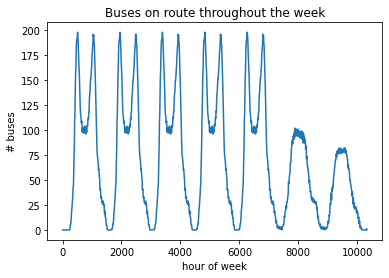

Minimum number of buses required is  198


In [8]:
import RouteZero.route as route
import matplotlib.pyplot as plt

trips_data_sel = trips_data[trips_data['route_short_name'].isin(routes_sel)]

times, buses_in_traffic = route.calc_buses_in_traffic(trips_data_sel, deadhead=0.1, resolution=10)

plt.plot(times, buses_in_traffic)
plt.title('Buses on route throughout the week')
plt.ylabel('# buses')
plt.xlabel('hour of week')
plt.show()

print('Minimum number of buses required is ', buses_in_traffic.max())

In [9]:
trips_data_sel = route.update_patronage(trips_data_sel, patronage)

Now calculate energy consumption for each route

In [12]:
from RouteZero.models import LinearRegressionAbdelatyModel
model = LinearRegressionAbdelatyModel()
ec_km, ec_total = model.predict_hottest(trips_data_sel, bus)

Plot energy consumption of routes on map

In [14]:
from RouteZero.map import create_map
map_title = "Route Energy Consumption between 0600 and 1200"
colorbar_str = 'energy per km'
m = create_map(trips_data_sel, shapes, ec_km, map_title, colorbar_str, window=[6, 12])
display(m)